In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pugna.activations
import pugna.layers

mpl.rcParams.update({"font.size": 16})

In [2]:
def plot_history(history, labels):
    plt.figure()
    for i, h in enumerate(history):
        loss = h.history["loss"]
        plt.plot(range(len(loss)), loss, label=labels[i])
    plt.yscale("log")
    plt.title('train')    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if "val_loss"  in history[0].history.keys():
        plt.figure()
        for h in history:
            loss = h.history["val_loss"]
            plt.plot(range(len(loss)), loss, ls='--')
        plt.yscale("log")
        plt.title('validation')

In [3]:
def plot_prediction_and_error(x, y, model, xlim=None):
    yhat = model.predict(x)
    yRes = y - yhat
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    axes[0].plot(x, y, 'o')
    axes[0].plot(x, yhat, 'o',markerfacecolor='none')
    axes[1].plot(x, yRes, 'o')
    
    if xlim:
        for ax in axes:
            ax.set_xlim(*xlim)
    
    plt.show()
    plt.close()

In [4]:
# https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy
class ThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') <= 1e-6:
            self.model.stop_training = True

In [5]:
x_file = './phase_X_train_scaled.npy'
y_file = './phase_y_train_scaled.npy'

In [6]:
def load_data(x_file, y_file, max_samples=None, input_dim=None, output_dim=None):
    """
    input_dim and output_dim.
    if specified then will only return that input and output dim.
    for testing purposes
    """
    x = np.load(x_file)
    y = np.load(y_file)
    
    if max_samples:
        x = x[:max_samples]
        y = y[:max_samples]
    
    if input_dim is not None:
        x = x[:,input_dim][:,np.newaxis]
    if output_dim is not None:
        y = y[:,output_dim][:,np.newaxis]
        
    return x, y

In [91]:
x, y = load_data(x_file, y_file, max_samples=30, input_dim=0, output_dim=0)

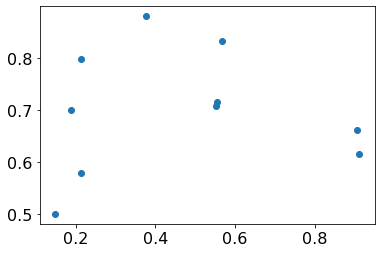

In [8]:
plt.figure()
plt.plot(x, y, 'o')

In [9]:
def compile_and_fit_model(model, x, y, optimizer=None, verbose=0, epochs=5000, batch_size=None):
    if batch_size is None:
        batch_size=32
    
    model.compile(loss='mse', optimizer=optimizer)
    
    # initialize tqdm callback with default parameters
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    
    callbacks=[tqdm_callback]
    
    callbacks.append(ThresholdCallback()) 
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=callbacks)
    
    return history, model

In [76]:
input_dim = x.shape[1]
output_dim = y.shape[1]

# units=256
# nscales=9
# scale_name='base2'

optimizer = tf.keras.optimizers.Adamax()
# optimizer = tf.keras.optimizers.Adam(0.001, amsgrad=True)
# optimizer = tf.keras.optimizers.Adagrad()
# optimizer = tf.keras.optimizers.Nadam()
# optimizer = tf.keras.optimizers.Ftrl()
# optimizer = tf.keras.optimizers.Adadelta()

# optimizer = tf.keras.optimizers.Adagrad()
# model = tf.keras.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(input_dim,)),
#         pugna.layers.ExU(128),
#         pugna.layers.ExU(32),
#         tf.keras.layers.Dense(output_dim)
#     ])

model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(320, activation='relu'),
        tf.keras.layers.Dense(320, activation='relu'),
        tf.keras.layers.Dense(output_dim)
    ])

In [92]:
%%time
historys = []
models = []
ntries = 10
batch_size = 10
for i in range(1, ntries+1):
    print(f"working: {i}/{ntries}")
    h_, m_ = compile_and_fit_model(model, x, y, epochs=10000, optimizer=optimizer, batch_size=batch_size)
    historys.append(h_)
    models.append(m_)

working: 1/10



working: 2/10



working: 3/10



working: 4/10



working: 5/10



working: 6/10



working: 7/10



working: 8/10



working: 9/10



working: 10/10



CPU times: user 7min 7s, sys: 1min 33s, total: 8min 41s
Wall time: 4min 1s


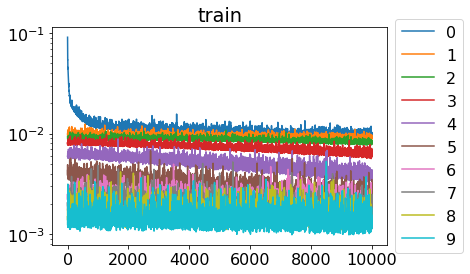

In [94]:
plot_history(historys, labels=list(range(ntries)))

In [95]:
def get_best_model_index(historys):
    return np.argmin([history.history['loss'][-1] for history in historys])

In [96]:
best_model = models[get_best_model_index(historys)]

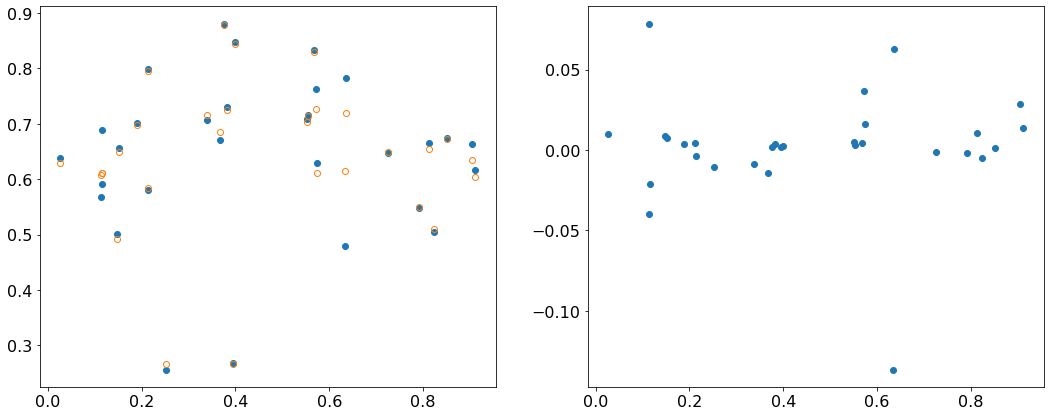

In [97]:
plot_prediction_and_error(x, y, best_model)

In [98]:
x_prime = np.linspace(0, 1, 10000)

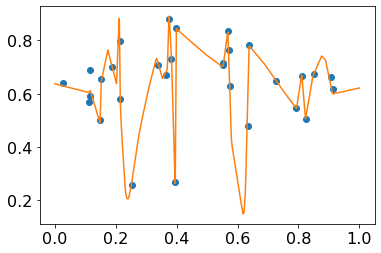

In [99]:
plt.figure()
plt.plot(x, y, 'o')
plt.plot(x_prime, best_model.predict(x_prime))